# Apple and Google NLP Twitter Sentiment Analysis
## Business Overview

## Introduction
In today's digital age, social media platforms like Twitter serve as an invaluable source of public sentiment and opinion. Understanding the sentiments of users on these platforms can provide valuable insights for businesses. In this project, the aim is to harness the power of Natural Language Processing (NLP) to analyze Twitter sentiment about products from two tech giants, Apple and Google.

## Business Understanding
Apple and Google are two of the most prominent companies in the tech industry, producing a wide range of products that have a significant impact on people's lives. Monitoring the sentiment expressed by Twitter users towards these companies and their products can help businesses make informed decisions. This sentiment analysis can inform product development, marketing strategies, and customer relations.

## Business Problem
The primary business problem that will be addressed is the need for a systematic and automated way to gauge the sentiment of tweets related to Apple and Google products. Twitter is a platform where millions of users express their opinions and experiences daily. Manual analysis of these tweets is not feasible due to the sheer volume of data. Therefore, there's need for a reliable NLP model that can classify tweets into positive, negative, or neutral sentiment categories.

## Research Question
* How do consumers perceive one company relative to the other?

## Main Objective
The main objective of this project is to build a proof-of-concept NLP model that can accurately rate the sentiment of tweets about Apple and Google products. This model will enable businesses to gain real-time insights into how their products are perceived by the Twitter community.

## Specific Objectives
* **Data Collection:** A dataset of tweets related to Apple and Google products will be gathered. This dataset should include tweets that express both positive and negative sentiments.

* **Data Preprocessing:** Cleaning and preprocessing the collected data to prepare it for NLP analysis. This includes tasks like text normalization, tokenization, and handling of missing or irrelevant data.

* **Model Development:** Developing a baseline NLP model for binary sentiment classification, categorizing tweets as either positive or negative. This model will serve as a starting point for further improvements.

* **Model Evaluation:** Evaluating the binary sentiment classifier using appropriate metrics like accuracy, precision, recall, and F1-score. This will help assess the model's performance and identify areas for improvement.

* **Multiclass Classification:** Extending the binary classifier to a multiclass classifier by incorporating a neutral sentiment category. This will provide a more nuanced understanding of sentiment.

* **Business Insights:** Interpret the results and provide actionable insights to businesses.

In conclusion, this project aims to create a valuable tool for businesses in the tech industry by leveraging NLP to understand and react to public sentiment on Twitter. By achieving the specific objectives outlined, the project will provide a scalable solution for sentiment analysis that can be adapted to other products and industries, ultimately enhancing decision-making processes and customer satisfaction.

## Metrics of Success
After modeling, the success metrics for the sentiment analysis on this project includes:

* **Accuracy:** Measure the accuracy of the sentiment classification model in correctly categorizing tweets into positive, negative, or neutral sentiments. This metric indicates the model's ability to make accurate predictions.

* **Precision, Recall, and F1 Score:** Calculate precision, recall, and F1 score to assess the model's performance in correctly identifying positive, negative, and neutral sentiments. These metrics provide insights into the model's ability to balance precision (correctly identifying positive/negative sentiments) and recall (identifying all positive/negative sentiments).

## Data Understanding
The data was sourced from [here](https://data.world/crowdflower/brands-and-product-emotions). Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.





In [75]:
# importing necessary packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from matplotlib import cm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("vader_lexicon")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Reading the Dataset 
# Use 'latin-1' encoding to handle special characters
review_df = pd.read_csv("judge-1377884607_tweet_product_company.csv", encoding="latin-1")
review_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The column names are overly lengthy and challenging to read. To improve readability, we can rename the columns.

In [3]:
# Confirming the changes
review_df.columns = ["tweet", "products", "emotion"]
review_df.head()

,tweet,products,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Checking at unique values of products and emotion to have a better understanding of what we are working with

In [4]:
# Displaying unique entries in "products"
review_df.products.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [5]:
# Displaying unique entries in "emotion"
review_df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Based on the unique values observed in the **"products"** and **"emotion"** columns, we can make several observations:

The **"products"** column contains a variety of product-related values, including specific Apple and Google products like 'iPhone,' 'iPad,' 'Google,' 'Android,' as well as more general categories like 'iPad or iPhone App,' 'Android App,' 'Other Google product or service,' and 'Other Apple product or service.' Additionally, there are some missing values (NaN).

The **"emotion"** column represents the sentiment or emotion associated with the tweets. It includes categories such as 'Negative emotion,' 'Positive emotion,' 'No emotion toward brand or product,' and "I can't tell."

Changing the names of the values in the emotion column for easy interpretability

In [6]:
# Replacing 'No emotion toward brand or product' with 'Neutral emotion'
#and 'I can't tell' with 'Unknown'
review_df['emotion'].replace({'No emotion toward brand or product': 'Neutral emotion', 
                               "I can't tell": 'Unknown'}, inplace=True)

In [7]:
# Confirming the changes while 
review_df.emotion.value_counts()

Neutral emotion     5389
Positive emotion    2978
Negative emotion     570
Unknown              156
Name: emotion, dtype: int64

In [8]:
# Checking structure of the dataset
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     9092 non-null   object
 1   products  3291 non-null   object
 2   emotion   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


From the above we can observe that we have a missing text for tweet and also were are missing some products of which the corresponding tweet was about.

### Dealing with missing values

In [9]:
# Inspecting the row with the missing tweet
review_df[pd.isna(review_df["tweet"])]

,tweet,products,emotion
6,NaN,NaN,Neutral emotion


We can see that both tweet and product information are missing in this row, so it would be appropriate to drop it.

In [10]:
# Droping the row
review_df.dropna(subset=["tweet"], inplace=True)

In [11]:
# Inspecting the rows where product column has missing value
review_df[pd.isna(review_df['products'])].head(10)


,tweet,products,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral emotion
33,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral emotion
34,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral emotion
35,At #sxsw. Oooh. RT @mention Google to Launch ...,NaN,Neutral emotion
37,SPIN Play - a new concept in music discovery f...,NaN,Neutral emotion
39,VatorNews - Google And Apple Force Print Media...,NaN,Neutral emotion
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,Neutral emotion
42,Hey #SXSW - How long do you think it takes us ...,NaN,Neutral emotion


In [12]:
#  Checking the percentage of the null values
missing_products_percentage = (review_df['products'].isna().sum() / len(review_df)) * 100
print(round(missing_products_percentage, 2))

63.8


These tweets are not really directed towards a specific product or brand so we can go ahead and fill the null values with "Unknown" as a placeholder value. Also, given that approximately 63.80% of the "products" column contains missing values, filling them with "Unknown" is a reasonable approach to ensure that we retain as much useful information as possible while preparing the data for analysis.

In [13]:
# Filling the null values with "Unknown"
review_df["products"].fillna("Unknown", inplace=True)

In [14]:
# Verifying that the missing values have been dealt with
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     9092 non-null   object
 1   products  9092 non-null   object
 2   emotion   9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


### Dropping some rows

Calculating the percentage of each emotion category

In [15]:
# Calculating the percentage of each emotion category
emotion_percentage = (review_df['emotion'].value_counts() / len(review_df)) * 100

# Display the percentage of each emotion
print(emotion_percentage)

Neutral emotion     59.260889
Positive emotion    32.754070
Negative emotion     6.269248
Unknown              1.715794
Name: emotion, dtype: float64


For this project, our focus is solely on emotions categorized as positive, neutral, or negative. Therefore, we will proceed to remove rows with the "Unknown" emotion category. It's worth noting that these rows account for only up to 1.7% of our dataset, making their removal a justifiable step.

In [16]:
# Dropping rows with "Unknown" emotion category
review_df = review_df[review_df.emotion != "Unknown" ]

# Checking the changes
review_df.emotion.value_counts()

Neutral emotion     5388
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

Checking and Dealing with Duplicates

In [17]:
# Calculating the number of duplicate rows 
len(review_df[review_df.duplicated()])

22

In [18]:
# Checking for duplicate rows in the DataFrame
review_df[review_df.duplicated()].head(10)


,tweet,products,emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,Unknown,Neutral emotion
2232,Marissa Mayer: Google Will Connect the Digital...,Unknown,Neutral emotion
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,Unknown,Neutral emotion
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",Unknown,Neutral emotion
5881,RT @mention Google to Launch Major New Social ...,Unknown,Neutral emotion


It appears that there are 22 duplicate rows. These duplicates will be removed, retaining only the first occurrence of each row.

In [19]:
# Remove duplicate rows and keep the first occurrence
review_df.drop_duplicates(inplace=True)

In [20]:
# Display information about the DataFrame
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     8914 non-null   object
 1   products  8914 non-null   object
 2   emotion   8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


Now we're going to clean the tweets from user mentions. This preprocessing step helps in removing user-specific information from the tweets while retaining the content.


In [21]:
# Creating a function that will be used to remove name tags

def remove_nametags(sentence):
    """A simple function to remove name tags"""
    clean_words = []
    for word in sentence.split():
        if "@" not in word:
            clean_words.append(word)
    return " ".join(clean_words)

review_df["tweet"] = review_df["tweet"].apply(remove_nametags)

review_df.head()

,tweet,products,emotion
0,I have a 3G iPhone. After 3 hrs tweeting at #R...,iPhone,Negative emotion
1,Know about ? Awesome iPad/iPhone app that you'...,iPad or iPhone App,Positive emotion
2,Can not wait for #iPad 2 also. They should sal...,iPad,Positive emotion
3,I hope this year's festival isn't as crashy as...,iPad or iPhone App,Negative emotion
4,great stuff on Fri #SXSW: Marissa Mayer (Googl...,Google,Positive emotion


### Exploratory Data Analysis

Exploratory data analysis is a critical step in the data analysis process that involves examining and visualizing dataset to gain insights and understand its characteristics. EDA helps in uncovering patterns, relationships, and potential issues in your data before diving into more advanced analyses. 

**Tweets with positve emotions**

We will start our exploration with tweets with positve emotions.


In [22]:
# Calculating the percentage of each emotion category
emotion_percentage = (review_df['emotion'].value_counts() / len(review_df)) * 100

# Display the percentage of each emotion
print(emotion_percentage)

Neutral emotion     60.298407
Positive emotion    33.318376
Negative emotion     6.383217
Name: emotion, dtype: float64


In [23]:
# Parsing positive tweets into new df
positive_df = review_df[review_df["emotion"]=="Positive emotion"]

positive_df


,tweet,products,emotion
1,Know about ? Awesome iPad/iPhone app that you'...,iPad or iPhone App,Positive emotion
2,Can not wait for #iPad 2 also. They should sal...,iPad,Positive emotion
4,great stuff on Fri #SXSW: Marissa Mayer (Googl...,Google,Positive emotion
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT wrote abo...,iPad or iPhone App,Positive emotion
...,...,...,...
9072,your iPhone 4 cases are Rad and Ready! Stop by...,iPhone,Positive emotion
9077,your PR guy just convinced me to switch back t...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [24]:
# Convert the "tweet" column into a list
positive_tweet = positive_df['tweet'].tolist()

# Display the first few elements of the list
positive_tweet[:5] 

["Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 'Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

### Tokenization
Splitting the tweets into units of observation.

In [25]:
def tokenize_tweets(tweets, preserve_case=False):
    """
    Tokenizes a list of tweets using the RegexpTokenizer.

        Returns:
    - list: A list of tokenized tweets where each tweet is represented as a list of tokens.
    """
    # Initialize the tokenizer
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    # Initialize an empty list to store tokenized tweets
    tokenized_tweets = []

    # Tokenize each tweet in the list
    for tweet in tweets:
        if preserve_case:
            tokenized_tweet = tokenizer.tokenize(tweet)
        else:
            tokenized_tweet = tokenizer.tokenize(tweet.lower())  
        tokenized_tweets.extend(tokenized_tweet)  

    return tokenized_tweets

In [26]:
# Tokenize positive tweets
positive_tokens = tokenize_tweets(positive_tweet)


In [27]:
# Displaying 50 most common token
freq = FreqDist(positive_tokens)
freq.most_common(50)

[('sxsw', 3136),
 ('the', 1591),
 ('link', 1214),
 ('to', 1156),
 ('ipad', 1025),
 ('at', 1021),
 ('apple', 932),
 ('rt', 922),
 ('for', 907),
 ('a', 796),
 ('google', 734),
 ('is', 643),
 ('in', 639),
 ('of', 639),
 ('i', 630),
 ('and', 582),
 ('store', 549),
 ('iphone', 548),
 ('s', 510),
 ('2', 504),
 ('it', 475),
 ('quot', 460),
 ('up', 458),
 ('on', 439),
 ('app', 400),
 ('new', 360),
 ('you', 336),
 ('an', 327),
 ('my', 305),
 ('with', 296),
 ('austin', 295),
 ('just', 241),
 ('this', 226),
 ('pop', 214),
 ('ipad2', 210),
 ('amp', 208),
 ('android', 208),
 ('be', 204),
 ('that', 196),
 ('out', 192),
 ('by', 175),
 ('from', 174),
 ('t', 173),
 ('have', 172),
 ('launch', 160),
 ('get', 158),
 ('are', 157),
 ('they', 150),
 ('one', 148),
 ('your', 147)]

Upon analyzing the 50 most common tokens in positive tweets related to Apple and Google products during the SXSW Conference, we have observed recurring terms and patterns.

It is apparent that "sxsw" is highly prevalent tokens in these tweets. Given that we are aware the tweets pertain to the SXSW Conference, we can consider excluding it by adding it to the stop words list. Furthermore, words such as 'link' and 'rt' appear to reference external links and retweets, respectively, and should be removed from our analysis. Additionally, we have noticed the frequent occurrence of common English words, often referred to as stopwords, including "the," "to," "at," and "for." These stopwords should also be filtered out as they do not provide substantial insights for our analysis.



### Lemmatization
Before removing stopwords, we are going to reduce words to their base or dictionary form.

In [28]:
# A simple function to be used for creating lemmas

def lemmatize_tokens(tokens):
    """
    Lemmatizes a list of tokens using the WordNetLemmatizer from NLTK.

    Args:
    - tokens (list): A list of tokens to be lemmatized.

    Returns:
    - list: A list of lemmatized tokens.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each token and store the result in a new list
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [29]:
# Lemmatizing positive tweet tokens
positive_tokens_lemm = lemmatize_tokens(positive_tokens)

# Displaying most common 50 tokens
freq = FreqDist(positive_tokens_lemm)
freq.most_common(50)

[('sxsw', 3136),
 ('the', 1591),
 ('link', 1218),
 ('to', 1156),
 ('ipad', 1025),
 ('at', 1021),
 ('apple', 933),
 ('rt', 922),
 ('for', 907),
 ('a', 870),
 ('google', 734),
 ('is', 643),
 ('in', 641),
 ('of', 639),
 ('i', 630),
 ('and', 582),
 ('store', 561),
 ('iphone', 548),
 ('2', 517),
 ('it', 511),
 ('s', 510),
 ('quot', 460),
 ('up', 458),
 ('on', 439),
 ('app', 400),
 ('new', 360),
 ('you', 336),
 ('an', 327),
 ('my', 305),
 ('with', 296),
 ('austin', 295),
 ('just', 241),
 ('this', 226),
 ('pop', 214),
 ('ipad2', 210),
 ('amp', 208),
 ('android', 208),
 ('be', 204),
 ('that', 196),
 ('out', 193),
 ('get', 181),
 ('t', 175),
 ('by', 175),
 ('from', 174),
 ('launch', 174),
 ('have', 172),
 ('are', 157),
 ('party', 152),
 ('one', 151),
 ('they', 150)]

### Removing Stopwords

In [30]:
# A simple function to be used in removing stopwords

# Additional custom stop words
custom_stop_words = ["sxsw", "link", "rt"]

def remove_stopwords(tokens):
    """
    Removes stop words from a list of tokens.

    Args:
    - tokens (list): A list of tokens to be filtered for stop words.

    Returns:
    - list: A list of tokens with stop words removed.
    """
    # Get the set of English stop words
    stop_words = set(stopwords.words("english") + custom_stop_words)
    
    # Filter out stop words from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    return filtered_tokens

In [31]:
# Positive filtered tokens
positive_filtered_tokens = remove_stopwords(positive_tokens_lemm)

In [32]:
# Displaying most common 50 tokens
freq = FreqDist(positive_filtered_tokens)
freq.most_common(50)

[('ipad', 1025),
 ('apple', 933),
 ('google', 734),
 ('store', 561),
 ('iphone', 548),
 ('2', 517),
 ('quot', 460),
 ('app', 400),
 ('new', 360),
 ('austin', 295),
 ('pop', 214),
 ('ipad2', 210),
 ('amp', 208),
 ('android', 208),
 ('get', 181),
 ('launch', 174),
 ('party', 152),
 ('one', 151),
 ('line', 145),
 ('great', 137),
 ('time', 136),
 ('via', 131),
 ('free', 126),
 ('day', 125),
 ('win', 124),
 ('social', 124),
 ('circle', 124),
 ('cool', 120),
 ('map', 119),
 ('like', 116),
 ('today', 114),
 ('ha', 108),
 ('go', 105),
 ('come', 103),
 ('w', 103),
 ('wa', 100),
 ('mobile', 100),
 ('sxswi', 97),
 ('awesome', 94),
 ('love', 93),
 ('good', 92),
 ('network', 91),
 ('temporary', 89),
 ('downtown', 88),
 ('opening', 88),
 ('check', 85),
 ('people', 83),
 ('open', 83),
 ('apps', 83),
 ('got', 81)]

In [33]:
# Creating a funtion that will be used to visualize the top 30 most common tokens
def plot_token_frequency(tokens, top_n=30, title="Token Frequency Distribution"):
    """
    Plot the frequency distribution of tokens.

    Args:
    - tokens (list): A list of tokens to analyze.
    - top_n (int): The number of top tokens to display in the plot.
    - title (str): The title of the plot.

    """
    # Calculate the frequency distribution
    freq = FreqDist(tokens)

    # Get the top N most common tokens and their frequencies
    common_tokens = freq.most_common(top_n)

    # Separate tokens and frequencies
    tokens, frequencies = zip(*common_tokens)

    # Create a bar plot for the most common tokens
    plt.figure(figsize=(8, 5))
    plt.bar(tokens, frequencies)
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout();

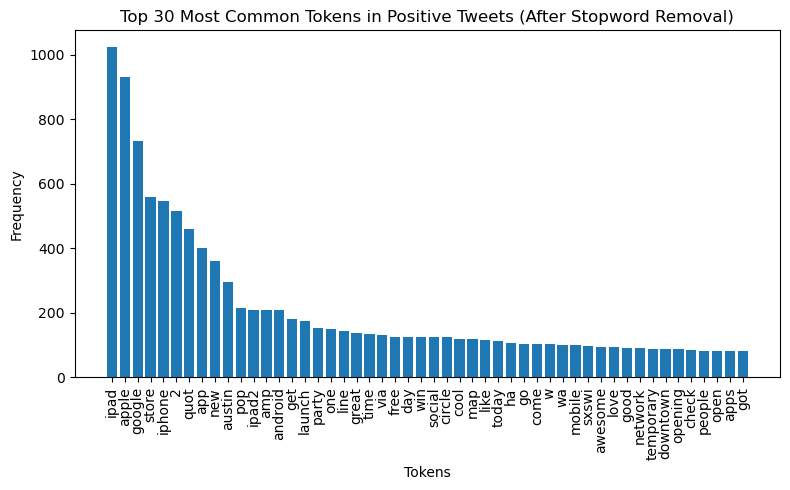

In [34]:
# Visualizing the top 30 most common tokens
plot_token_frequency(positive_filtered_tokens, top_n=50, 
                     title="Top 30 Most Common Tokens in Positive Tweets (After Stopword Removal)")

In the frequency distribution of the most common tokens in positive tweets after removing stopwords and lemmatizing, several interesting patterns emerge:

* **Apple Products Shine:** The tokens **"iPad," "Apple,"** and **"iPhone"** dominate the positive tweets, reflecting a strong presence of Apple products in discussions. These products seem to generate substantial positive sentiment among users.

* **Google's Influence: "Google"** also appears frequently, indicating that Google's presence and products are a notable part of the conversation at the event.

* **Tech Enthusiasm:** The presence of terms like **"app," "Android,"** and **"new"** suggests a tech-savvy and innovative atmosphere at the event, with attendees excited about new applications and technologies.

* **Event-Specific Terms: "Austin"** and reflect the event's location and, emphasizing its central role in these tweets.

* **Community and Sharing:** Words like **"amp," "via,"** and **"party"** suggest a sense of community and sharing among attendees, which is common at events like SXSW.

### WordCloud for Positive Tweets
WordCloud is a data visualization technique used to represent text data in a visually engaging and intuitive way.

In [35]:
# A function to be used to generate worldcould

def generate_wordcloud(tokens, title="WordCloud"):
    """
    Generate and display a WordCloud from a list of tokens.

    Parameters:
    - tokens (list): List of tokens for generating the WordCloud.
    - title (str): Title for the WordCloud plot (optional).

    """
    # Join the list of tokens into a single string
    text = ' '.join(tokens)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # Display the WordCloud plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis("off");

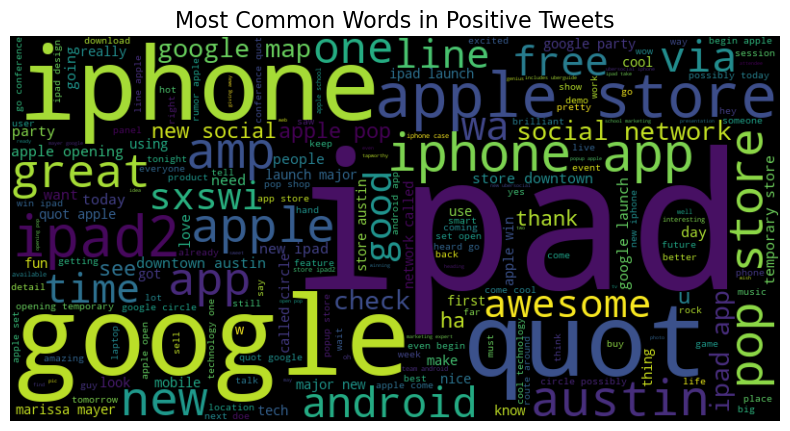

In [36]:
# Generating word cloud
cloud_positive_tweet = generate_wordcloud(positive_filtered_tokens,
                                title="Most Common Words in Positive Tweets")

This above analysis highlights the prominent themes and keywords in positive tweets, shedding light on the topics that resonate most with participants at SXSW.

**Tweets with negative emotions**

In [37]:
#parsing positive tweets into new df
negative_df = review_df[review_df["emotion"]=="Negative emotion"]

negative_df

,tweet,products,emotion
0,I have a 3G iPhone. After 3 hrs tweeting at #R...,iPhone,Negative emotion
3,I hope this year's festival isn't as crashy as...,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
38,- False Alarm: Google Circles Not Coming NowÛ...,Google,Negative emotion
64,Again? RT Line at the Apple store is insane.. ...,Unknown,Negative emotion
...,...,...,...
8973,Google guy at #sxsw talk is explaining how he ...,Unknown,Negative emotion
8981,I think my effing hubby is in line for an #iPa...,iPad,Negative emotion
9008,I'm pretty sure the panelist that thinks &quot...,Apple,Negative emotion
9043,Hey is anyone doing #sxsw signing up for the g...,Unknown,Negative emotion


In [38]:
# Convert the "tweet" column into a list
negative_tweet = negative_df['tweet'].tolist()

# Display the first few elements of the list
negative_tweet[:5] 

['I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.',
 "I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
 '- False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW',
 'Again? RT Line at the Apple store is insane.. #sxsw']

### Tokenization

In [39]:
# Tokenize negative tweets
negative_tokens = tokenize_tweets(negative_tweet)

# Displaying 10 most common token
freq = FreqDist(negative_tokens)
freq.most_common(10)

[('sxsw', 585),
 ('the', 314),
 ('to', 257),
 ('ipad', 195),
 ('i', 178),
 ('quot', 172),
 ('iphone', 162),
 ('is', 159),
 ('a', 155),
 ('google', 151)]

### Lemmatization

In [40]:
# Lemmatizing negative tweet tokens
negative_tokens_lemm = lemmatize_tokens(negative_tokens)

# Displaying most common 10 tokens
freq = FreqDist(negative_tokens_lemm)
freq.most_common(10)

[('sxsw', 585),
 ('the', 314),
 ('to', 257),
 ('ipad', 195),
 ('a', 194),
 ('i', 178),
 ('quot', 172),
 ('iphone', 162),
 ('is', 159),
 ('google', 151)]

### Removing Stopwords

In [41]:
# Negative filtered tokens
negative_filtered_tokens = remove_stopwords(negative_tokens_lemm)

# Displaying most common 50 tokens
freq = FreqDist(negative_filtered_tokens)
freq.most_common(50)

[('ipad', 195),
 ('quot', 172),
 ('iphone', 162),
 ('google', 151),
 ('apple', 123),
 ('2', 72),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('circle', 37),
 ('need', 35),
 ('social', 31),
 ('ha', 31),
 ('apps', 30),
 ('design', 29),
 ('people', 29),
 ('austin', 28),
 ('get', 25),
 ('wa', 24),
 ('android', 24),
 ('one', 23),
 ('think', 23),
 ('time', 23),
 ('line', 22),
 ('amp', 22),
 ('launch', 22),
 ('day', 22),
 ('today', 21),
 ('look', 21),
 ('say', 20),
 ('would', 19),
 ('news', 18),
 ('network', 18),
 ('phone', 18),
 ('fail', 18),
 ('year', 17),
 ('headache', 17),
 ('1', 17),
 ('go', 17),
 ('battery', 17),
 ('pop', 17),
 ('long', 17),
 ('product', 17),
 ('user', 15),
 ('thing', 15),
 ('good', 15),
 ('see', 15),
 ('much', 15),
 ('company', 15)]

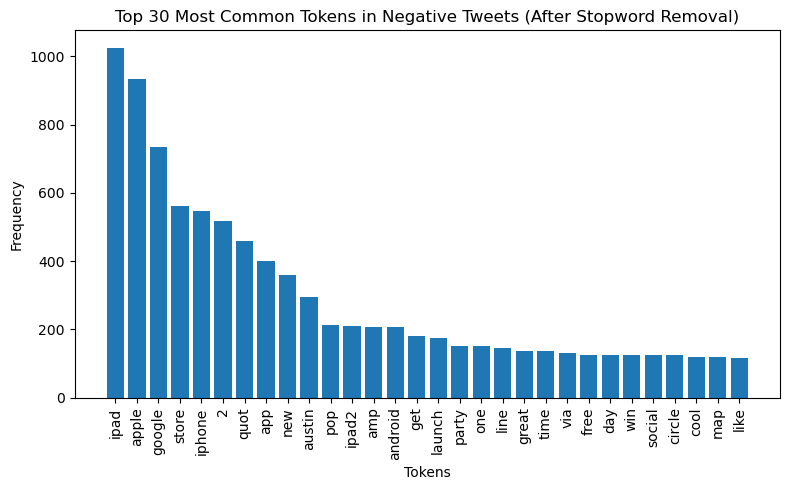

In [42]:
# Visualizing the top 30 most common tokens
plot_token_frequency(positive_filtered_tokens, top_n=30, 
                     title="Top 30 Most Common Tokens in Negative Tweets (After Stopword Removal)")

### WordCloud for Negative Tweets

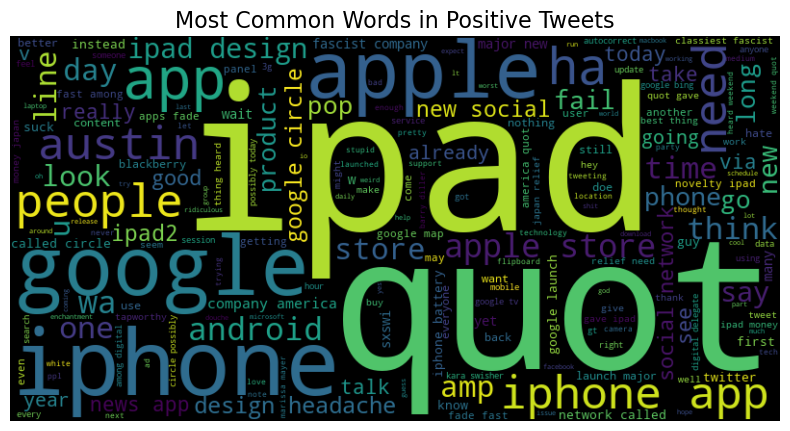

In [43]:
# Generating word cloud
cloud_negative_tweet = generate_wordcloud(negative_filtered_tokens,
                                title="Most Common Words in Positive Tweets")

While analyzing the most common tokens in positive and negative tweets, it's evident that certain words like "iPad," "Apple," "Google," and "iPhone" dominate both sentiment categories. However, merely focusing on sentiment alone might not provide a comprehensive understanding of the underlying trends and insights. Feature engineering will be done to consider specific companies and products.

Analyzing tweets based on specific companies( Apple and Google) will allow for a deeper dive into consumer opinions about each entity. 

### Feature Engeneering

In [44]:
# Displaying unique entries in "products"
review_df.products.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'Unknown',
       'Android', 'Apple', 'Android App',
       'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [45]:
# Feature engineering to have three categories: "Google," "Apple," and "Unknown"
review_df['brand'] = review_df['products'].replace({
    'iPhone': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPad': 'Apple',
    'Google': 'Google',
    'Unknown': 'Unknown',
    'Android': 'Google',
    'Apple': 'Apple',
    'Android App': 'Google',
    'Other Google product or service': 'Google',
    'Other Apple product or service': 'Apple'
})

# Drop the original "products" column
review_df.drop(columns=['products'], inplace=True)

# Display unique entries in the "brand" column
review_df['brand'].unique()

array(['Apple', 'Google', 'Unknown'], dtype=object)

### Sentiment Analysis of Apple-Related Tweets

In [46]:
# Filtering the DataFrame to select tweets associated with Apple
apple_tweets_df = review_df[review_df['brand'] == 'Apple']

# Converting the selected tweets to a list
apple_tweets_list = apple_tweets_df['tweet'].tolist()

# Display the first few elements of the list
apple_tweets_list[:5]

['I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.',
 "Know about ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 'Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'Beautifully smart and simple idea RT wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

In [47]:
#tokenize tweets
tokens_apple = tokenize_tweets(apple_tweets_list)
#lemmatize tweets
tokens_apple_lemm = lemmatize_tokens(tokens_apple)
#remove stop words using the same stop words list
tokens_apple_filtered = remove_stopwords(tokens_apple_lemm)

# Displaying most common 20 tokens
freq = FreqDist(tokens_apple_filtered)
freq.most_common(20)

[('ipad', 1151),
 ('apple', 1003),
 ('iphone', 641),
 ('store', 571),
 ('2', 520),
 ('quot', 376),
 ('app', 351),
 ('austin', 275),
 ('new', 227),
 ('pop', 221),
 ('ipad2', 203),
 ('line', 153),
 ('get', 151),
 ('one', 150),
 ('amp', 145),
 ('like', 112),
 ('ha', 107),
 ('via', 106),
 ('win', 104),
 ('go', 104)]

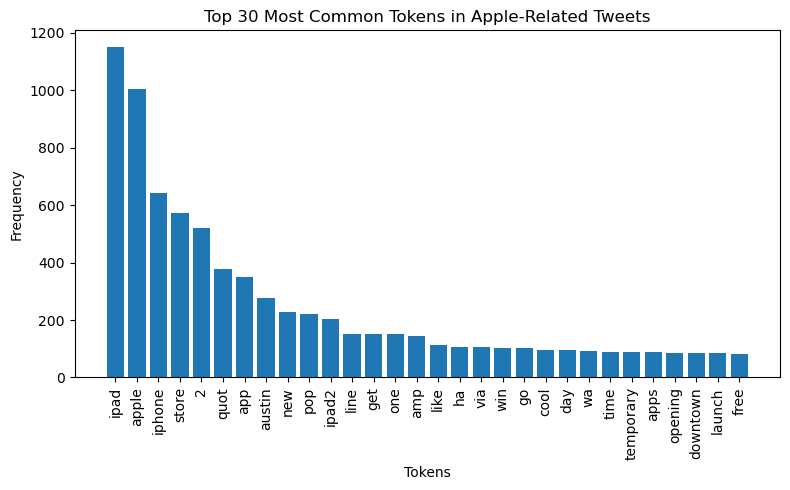

In [48]:
# Visualizing the top 30 most common tokens in Apple tweets
plot_token_frequency(tokens_apple_filtered, top_n=30, 
                     title="Top 30 Most Common Tokens in Apple-Related Tweets")

**WordCloud for Apple-related tweets**

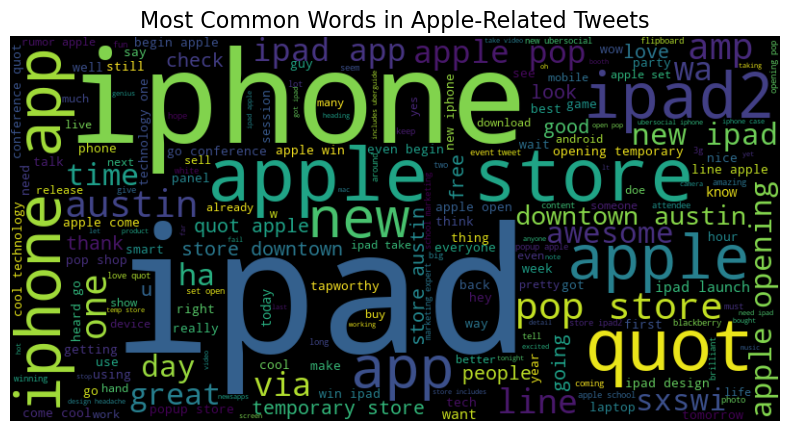

In [49]:
# Generating word cloud
cloud_apple_tweet = generate_wordcloud(tokens_apple_filtered,
                                title="Most Common Words in Apple-Related Tweets")

We can see that the most common tokens in tweets related to Apple predominantly revolve around specific Apple products such as the "iPad," "iPhone," and "Apple" itself, illustrating a clear focus on these core elements in the discussions. Additionally, terms like "store," "app," and "Austin" suggest an association with Apple's physical and virtual storefronts as well as its presence at events like #SXSW in Austin

**Percentage of Positive, Neutral and Negative Sentiments of Apple-related tweets**

In [50]:
# A funtion that will return a DataFrame with sentiment percentages.
def calculate_sentiment_percentages(df, emotion_column):
    """
    Calculate sentiment percentages from a DataFrame containing emotions.

    Args:
    - df (pd.DataFrame): The DataFrame containing the emotion data.
    - emotion_column (str): The name of the column containing emotion labels.

    Returns:
    - pd.DataFrame: A DataFrame with sentiment percentages sorted in descending order.
    """
    # Calculate sentiment percentages
    sentiment_counts = df[emotion_column].value_counts(normalize=True) * 100

    # Create a DataFrame to display the sentiment percentages
    df_sentiment = pd.DataFrame(sentiment_counts).reset_index()
    df_sentiment.columns = ['emotion', 'percentage']

    # Sort the DataFrame by percentage in descending order
    df_sentiment.sort_values('percentage', ascending=False, inplace=True)

    return df_sentiment

In [51]:
# Displying the emotions and corresponding percentages for Apple-related tweets
df_apple_sentiment = calculate_sentiment_percentages(apple_tweets_df, 'emotion')
df_apple_sentiment

,emotion,percentage
0,Positive emotion,81.143096
1,Negative emotion,16.145181
2,Neutral emotion,2.711723


In [52]:
# A function that will be used to visualize the percentages in a graph
def plot_sentiment_distribution(df, x_column, 
                                y_column, 
                                colors=None, 
                                title=None, 
                                xlabel=None, 
                                ylabel=None, 
                                invert_yaxis=True
                                ):
    """
    Create a bar plot to visualize sentiment distribution.

    """
    plt.figure(figsize=(5, 3))
    plt.barh(df[x_column], df[y_column], color=colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if invert_yaxis:
        plt.gca().invert_yaxis()
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Annotate the bars with percentage values
    for index, row in df.iterrows():
        plt.text(row[y_column], index,
                  f'{row[y_column]:.2f}%',
                    va='center', fontsize=12, color='black');
    

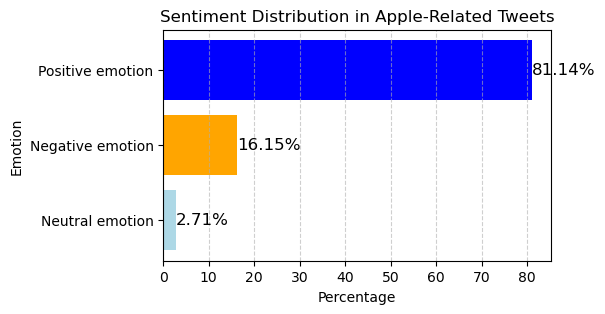

In [53]:
# Creating bar plot to visaulize Apple-related sentiment distribution
plot_sentiment_distribution(df_apple_sentiment, 'emotion', 'percentage',
                             colors=['blue', 'orange', 'lightblue'],
                            title='Sentiment Distribution in Apple-Related Tweets',
                              xlabel='Percentage', ylabel='Emotion')

The sentiment analysis of Apple-related tweets reveals a significant dominance of **positive emotions**, constituting approximately **81.14%** of the sentiment distribution. In contrast, **negative emotions** account for a considerably smaller proportion, standing at **16.15%**. **Neutral emotions** are relatively less prevalent, representing only **2.71%** of the analyzed tweets. 

This observation underscores the overwhelmingly positive sentiment surrounding Apple products in the Twitter discussions, indicating a strong and favorable perception among users. However, the presence of some negative and neutral sentiments suggests that Apple's products and services do not elude occasional criticism or indifference within the social media landscape.

### Sentiment Analysis of Google-Related Tweets

In [54]:
# Filtering the DataFrame to select tweets associated with Google
google_tweets_df = review_df[review_df['brand'] == 'Google']

# Converting the selected tweets to a list
google_tweets_list = google_tweets_df['tweet'].tolist()

# Display the first few elements of the list
google_tweets_list[:5]

["great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Excited to meet the at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail',
 "Find &amp; Start Impromptu Parties at #SXSW With http://bit.ly/gVLrIn I can't wait til the Android app comes out.",
 'Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer by far, best looking Android app to date.']

In [55]:
#tokenize tweets
tokens_google = tokenize_tweets(google_tweets_list)
#lemmatize tweets
tokens_google_lemm = lemmatize_tokens(tokens_google)
#remove stop words using the same stop words list
tokens_google_filtered = remove_stopwords(tokens_google_lemm)

# Displaying most common 20 tokens
freq = FreqDist(tokens_google_filtered)
freq.most_common(20)

[('google', 782),
 ('quot', 213),
 ('android', 167),
 ('new', 142),
 ('circle', 136),
 ('social', 115),
 ('map', 110),
 ('party', 103),
 ('launch', 94),
 ('network', 89),
 ('app', 73),
 ('mayer', 67),
 ('today', 66),
 ('mobile', 65),
 ('amp', 59),
 ('called', 59),
 ('great', 56),
 ('marissa', 56),
 ('time', 56),
 ('major', 56)]

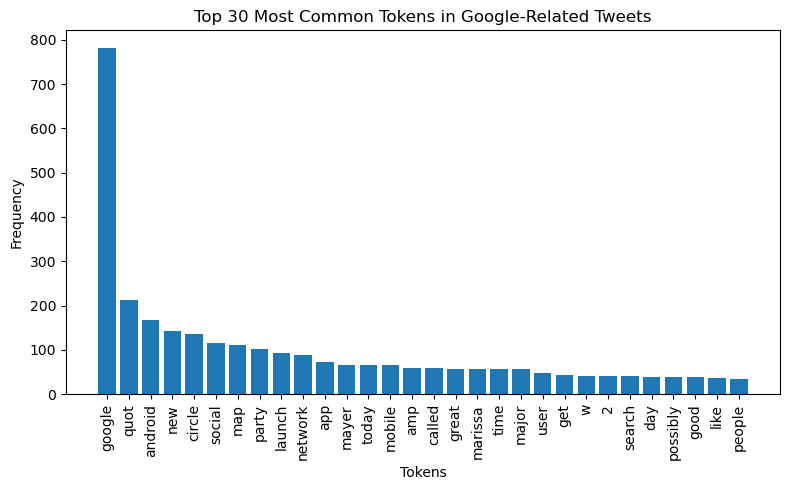

In [56]:
# Visualizing the top 30 most common tokens in Google tweets
plot_token_frequency(tokens_google_filtered, top_n=30, 
                     title="Top 30 Most Common Tokens in Google-Related Tweets")

**WordCloud for Google-related tweets**

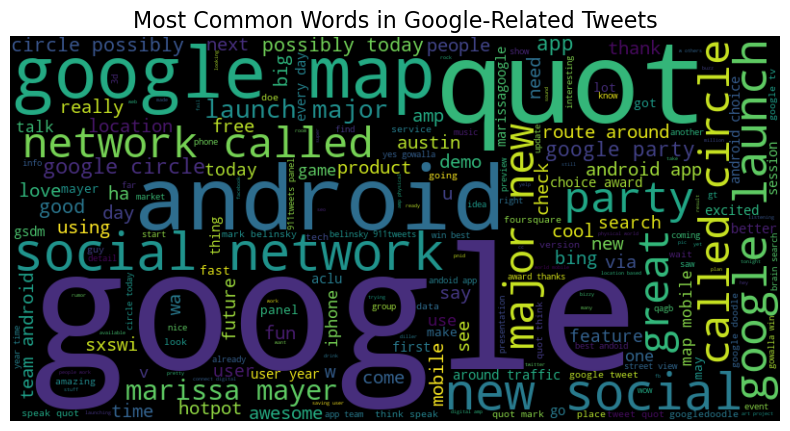

In [57]:
# Generating word cloud
cloud_google_tweet = generate_wordcloud(tokens_google_filtered,
                                title="Most Common Words in Google-Related Tweets")

We can observe that the most common tokens in tweets related to Google predominantly revolve around the brand itself, with mentions of "Google" being highly frequent. Additionally, terms like "Android," "Circles," "Social," "Mayer," and "map" suggest discussions about specific Google products, services, and notable figures, such as Marissa Mayer. Notably, "app" and "amp" also appear frequently, indicating a focus on Google's mobile applications and related discussions. The prevalence of "quot" suggests the inclusion of quotations or quotes in the tweets, possibly for reference or emphasis. Overall, the dominant presence of Google-related terms underscores the central role of Google and its products in the Twitter conversations, reflecting a substantial engagement with the brand and its offerings within the online community.

**Percentage of Positive, Neutral and Negative Sentiments of Google-related tweets**

In [58]:
# Displying the emotions and corresponding percentages for Google-related tweets
df_google_sentiment = calculate_sentiment_percentages(google_tweets_df, 'emotion')
df_google_sentiment

,emotion,percentage
0,Positive emotion,82.077626
1,Negative emotion,14.954338
2,Neutral emotion,2.968037


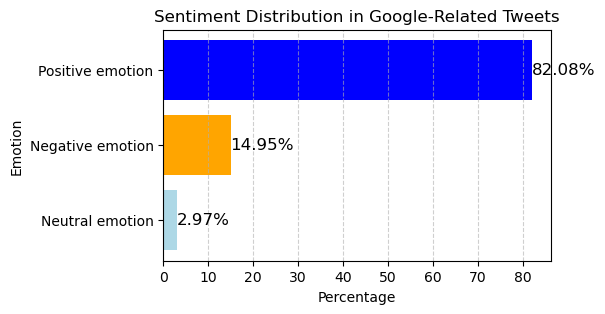

In [59]:
# Creating bar plot to visaulize Google-related sentiment distribution
plot_sentiment_distribution(df_google_sentiment, 'emotion', 'percentage',
                             colors=['blue', 'orange', 'lightblue'],
                            title='Sentiment Distribution in Google-Related Tweets',
                              xlabel='Percentage', ylabel='Emotion')

The sentiment analysis of Google-related tweets demonstrates a notably dominant **positive sentiment**, accounting for approximately **82.08%** of the overall sentiment distribution, with **negative emotions** representing a considerably smaller proportion at **14.95%**, and **neutral emotions** making up **2.97%** of the discussions, highlighting a predominantly positive sentiment surrounding Google on Twitter.

### Modelling
The initial step will involve binary classification, where the model's objective is to accurately predict whether a tweet falls under the "Positive" or "Negative" category. Following this will be multiclass classification, where the "Neutral" category will be introduced, expanding the classification task into a three-way categorization.

Three models will be used and tune the best fitting model to get optimal parameters.
* Logistic Regression
* Gaussian Naive Bayes
* Random Forest Classifier

### Binary classification

### Data Preprocessing

In [60]:
# Getting the unique entities in "emotio" from our DataFrame
review_df['emotion'].unique()

array(['Negative emotion', 'Positive emotion', 'Neutral emotion'],
      dtype=object)

Since we are initially focusing on binary classification, we will remove the "Neutral emotion" category from our DataFrame.

In [61]:
# Creating a binary DataFrame with no "Neutral emotion" category
binary_df = review_df[review_df['emotion'] != 'Neutral emotion']

# Confirming the changes
binary_df['emotion'].unique()

array(['Negative emotion', 'Positive emotion'], dtype=object)

Label encoding each unique emotion category to allow categorical data to be used in machine learning algorithms. "Positive emotion" will be mapped to 1, and "Negative emotion" to 0.

In [62]:
# Creating a mapping dictionary
binary_emotion_mapping = {'Positive emotion': 1, 'Negative emotion': 0}

# Mapping the 'emotion' column to numerical values using the dictionary
binary_df['emotion'] = binary_df['emotion'].map(binary_emotion_mapping)

# Confirming the changes
binary_df['emotion'].unique()

array([0, 1], dtype=int64)

In [63]:
# Checking if we have class imbalance
binary_df['emotion'].value_counts(normalize=True) * 100

1    83.922012
0    16.077988
Name: emotion, dtype: float64

The class distribution analysis of the binary dataset reveals an imbalance, with approximately 83.92% of the samples belonging to "Positive emotion" class and 16.08% to "Negative emotion". This indicates a potential class imbalance issue that should be considered during the modeling process. It is essential to be mindful of class imbalance to ensure that the machine learning model's performance is not biased towards the majority class.

**Train, test split**

In [64]:
# Splitting the features into indipendent and target variable
X = binary_df['tweet']
y = binary_df['emotion']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Logistic Regression**

In [65]:
# Defining the tokenizer function
def tokenize_text(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    return tokenizer.tokenize(text.lower())

# Selecting stopword 
# Additional custom stop words
custom_stop_words = ["sxsw", "link", "rt"]

stop_words = list(stopwords.words("english")) + custom_stop_words


In [66]:
# Creating a pipeline
clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_text, 
                                   stop_words=None, 
                                   norm='l2')), 
    ('os', RandomOverSampler(random_state=42)), 
    ('clf', LogisticRegressionCV(class_weight='balanced', random_state=42, cv=3))
])

# Fit the pipeline
clf_pipe.fit(X_train, y_train)

# Make predictions
y_pred = clf_pipe.predict(X_test)


The model's precision is           87.54%
Training Score: 0.99
Test Score: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.38      0.50       106
           1       0.90      0.98      0.94       602

    accuracy                           0.89       708
   macro avg       0.82      0.68      0.72       708
weighted avg       0.88      0.89      0.87       708



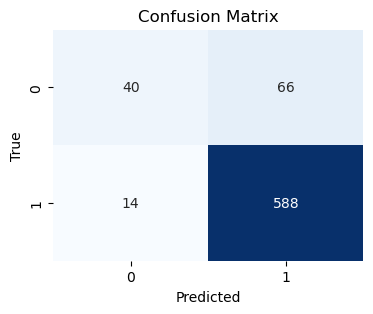

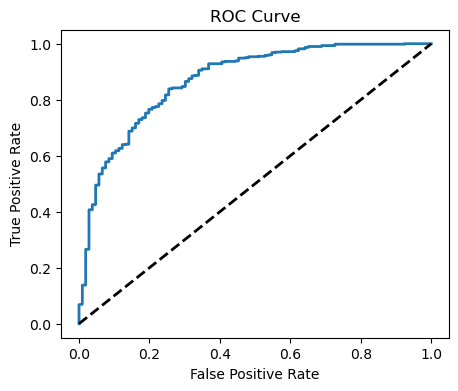

In [77]:
# A funtion that will be used for classification evaluation
def evaluate_classification(y_true, y_pred, clf_pipe):
    # Calculating model's precision
    print(f"The model's precision is \
          {precision_score(y_test, y_pred, average='weighted'):.2%}")

    # Calculating and printing the training score
    training_score = clf_pipe.score(X_train, y_train)
    print(f"Training Score: {training_score:.2f}")
    
    # Calculating and printing test score
    test_score = clf_pipe.score(X_test, y_test)
    print(f"Test Score: {test_score:.2f}\n")

    # Classification Report
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)


    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    # ROC Curve
    y_prob = clf_pipe.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# Perform classification evaluation
evaluate_classification(y_test, y_pred, clf_pipe)

The baseline model has shown promising results in classifying sentiment in tweets as either positive (1) or negative (0). The model achieved a high training score of 1.00, indicating a perfect fit on the training data. When tested on unseen data, it achieved a respectable test score of 0.88, indicating that it generalizes well to new data. The classification report reveals that the model performs particularly well in identifying positive sentiment with a high precision, recall, and F1-score. However, there is room for improvement in recognizing negative sentiment, as indicated by slightly lower precision and recall. The confusion matrix shows that the model correctly identified the majority of positive sentiment tweets but had some difficulty in accurately classifying negative sentiment tweets. This baseline model provides a solid starting point for further refinement and optimization to enhance its performance, especially in identifying negative sentiment tweets.

**Gaussian Naive Bayes**

In [80]:
# Creating a pipeline 
clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_text, 
                                   stop_words=None)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

# Fitting the pipeline on the training data
clf_pipe.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf_pipe.predict(X_test)

The model's precision is           88.83%


Training Score: 0.98
Test Score: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.67      0.63       106
           1       0.94      0.92      0.93       602

    accuracy                           0.88       708
   macro avg       0.77      0.79      0.78       708
weighted avg       0.89      0.88      0.88       708



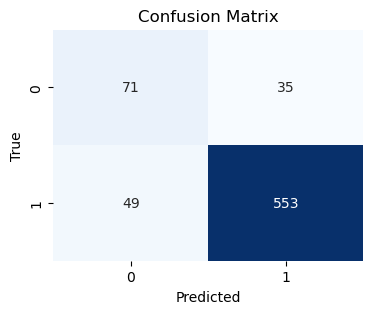

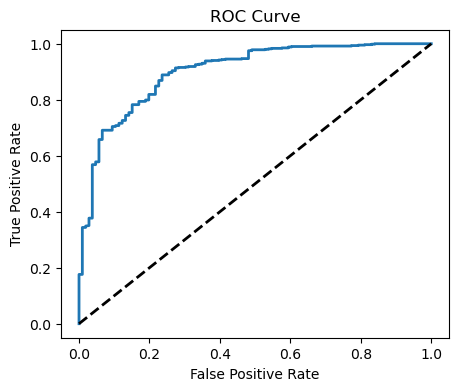

In [81]:
# Perform classification evaluation
evaluate_classification(y_test, y_pred, clf_pipe)

The second model, built using a Multinomial Naive Bayes classifier demonstrates a commendable performance in sentiment classification for tweets. It achieved a high training score of 0.98, indicating a strong fit to the training data, and maintained an impressive test score of 0.88 when evaluated on unseen data. The classification report shows that the model exhibits balanced precision, recall, and F1-score for both positive and negative sentiment categories. While the model excels at identifying positive sentiment tweets, it also displays notable improvements in identifying negative sentiment tweets compared to the baseline model. The confusion matrix illustrates that the model is effective at correctly classifying the majority of both positive and negative sentiment tweets. This second model serves as a substantial enhancement to the baseline and provides a robust foundation for sentiment analysis on Twitter data, with the potential for further fine-tuning and optimization.

**Random Forest**

In [82]:
# Creating a pipeline
clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_text, 
                                   stop_words=None)), 
    ('os', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, 
                                   criterion='entropy', max_depth=None, 
                                   min_samples_leaf=2))])
# Fitting the pipeline on the training data
clf_pipe.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf_pipe.predict(X_test)

The model's precision is           87.54%
Training Score: 0.99
Test Score: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.38      0.50       106
           1       0.90      0.98      0.94       602

    accuracy                           0.89       708
   macro avg       0.82      0.68      0.72       708
weighted avg       0.88      0.89      0.87       708



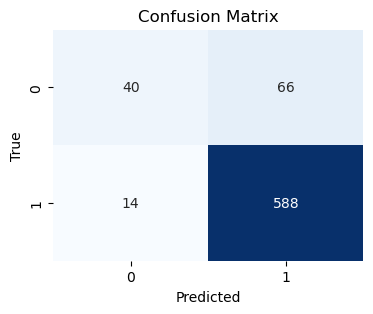

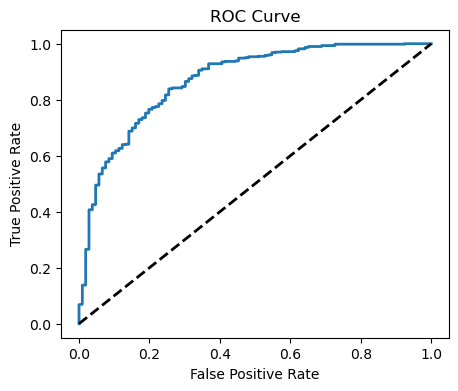

In [83]:
# Perform classification evaluation
evaluate_classification(y_test, y_pred, clf_pipe)

The third model, utilizing a Random Forest Classifier continues to demonstrate a high level of performance in sentiment classification for tweets. It achieved an outstanding training score of 0.99, indicating an excellent fit to the training data, and maintained a robust test score of 0.89 when evaluated on unseen data. The classification report reveals strong precision, recall, and F1-score for both positive and negative sentiment categories. The model excels at identifying positive sentiment tweets and exhibits a notable improvement in precision for negative sentiment tweets compared to the previous models. The confusion matrix indicates that the model effectively classifies the majority of positive and negative sentiment tweets.

The second model, employing the Multinomial Naive Bayes classifier, stands out as the most effective among the three models, considering all our success metrics. It consistently maintains a high test score of 0.88, coupled with impressive precision and recall values for both sentiment categories. This model achieves an F1-score of 0.93 for positive sentiment and 0.63 for negative sentiment. Consequently, we intend to fine-tune its hyperparameters to further optimize its performance.

In [86]:
# Creating a pipeline 
clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_text, 
                                   stop_words=None)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'clf__alpha': [0.001, 0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='f1_macro', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


Best Hyperparameters: {'clf__alpha': 1}


**Tuned Gaussian Naive Bayes**

In [87]:
# Creating a pipeline 
clf_tuned_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_text, 
                                   stop_words=None)),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', MultinomialNB(alpha=1))
])


# Fitting the pipeline on the training data
clf_tuned_pipe.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf_tuned_pipe.predict(X_test)

The model's precision is           89.76%
Training Score: 0.95
Test Score: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.79      0.64       106
           1       0.96      0.88      0.92       602

    accuracy                           0.87       708
   macro avg       0.75      0.84      0.78       708
weighted avg       0.90      0.87      0.88       708



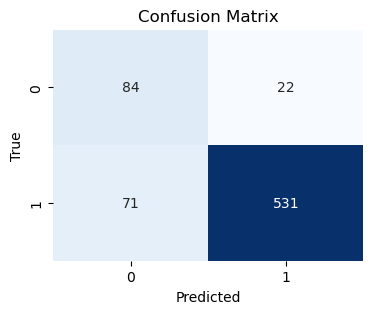

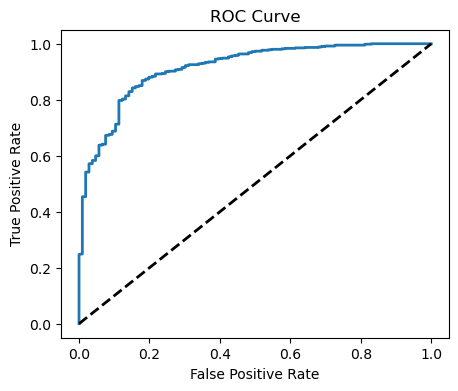

In [88]:
# Perform classification evaluation
evaluate_classification(y_test, y_pred, clf_tuned_pipe)

The last model, which was fine-tuned after hyperparameter optimization, demonstrates noticeable improvements in comparison to the previous model. The precision has increased to 89.76%, signifying that a higher percentage of predicted positive sentiments are now correctly classified as positive. Additionally, the recall for class 0 (negative sentiment) has risen to 79%, indicating that the model is more effective at accurately identifying negative sentiments. The model maintains a relatively high F1-score of 0.64 for class 0(negative sentiment) and an impressive F1-score of 0.92 for class 1 (positive sentiment). Overall, the model exhibits enhanced precision and a well-balanced performance, making it a strong choice for sentiment analysis tasks.

### Multiclass classification

### Data preprocessing

In [89]:
# Getting the unique entities in "emotio" from our DataFrame
review_df['emotion'].unique()

array(['Negative emotion', 'Positive emotion', 'Neutral emotion'],
      dtype=object)

In [90]:
# Creating a mapping dictionary
multi_emotion_mapping = {'Positive emotion': 1, 'Negative emotion': 0, 'Neutral emotion': 2}

# Mapping the 'emotion' column to numerical values using the dictionary
review_df['emotion'] = review_df['emotion'].map(multi_emotion_mapping)

# Confirming the changes
review_df['emotion'].unique()

array([0, 1, 2], dtype=int64)

In [91]:
# Checking for class imbalance
review_df['emotion'].value_counts(normalize=True) * 100

2    60.298407
1    33.318376
0     6.383217
Name: emotion, dtype: float64

As observed, class imbalance remains a concern that needs to be addressed during modeling. We will utilize RandomOverSampler to mitigate this issue and ensure a more balanced representation of the classes in our dataset.